In [1]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import json

# Dataset and model paths

In [2]:
training_path = '../model_data/training_data.csv'
validation_path = '../model_data/validation_data.csv'
testing_path = '../model_data/testing_data.csv'

model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Dataset reading

In [5]:
COORD_DIMS = 2  # (x, y)
COORD_COUNT = 21 * COORD_DIMS  # total number of landmark coordinates per hand

X_train = np.loadtxt(training_path, delimiter=',', dtype='float32', usecols=list(range(1, COORD_COUNT + 1)))
y_train = np.loadtxt(training_path, delimiter=',', dtype='int32', usecols=(0))

X_validation = np.loadtxt(validation_path, delimiter=',', dtype='float32', usecols=list(range(1, COORD_COUNT + 1)))
y_validation = np.loadtxt(validation_path, delimiter=',', dtype='int32', usecols=(0))

X_test = np.loadtxt(testing_path, delimiter=',', dtype='float32', usecols=list(range(1, COORD_COUNT + 1)))
y_test = np.loadtxt(testing_path, delimiter=',', dtype='int32', usecols=(0))

# final dataset formation 
X_concat = np.concatenate([X_train, X_validation])
y_concat = np.concatenate([y_train, y_validation])

X_final, X_validation, y_final, y_validation = train_test_split(
    X_concat, y_concat,
    test_size=0.1,
    stratify=y_concat
)

# when tuning hyperparameters, X/y_final = X/y_train, and X/y_validation = X/y_validation
#X_final = X_train
#y_final = y_train

#X_validation = X_validation
#y_validation = y_validation

# Class balancing

In [4]:
classes = np.unique(y_final)

NUM_CLASSES = len(classes)  # used in MLP layer and class weight computation

# balancing
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_final)

# map each class to its corresponding weight
class_weight_dict = dict(zip(classes, class_weights))

In [5]:
# for reference
print(class_weight_dict)

{0: 1.0697168482546757, 1: 1.06759741098803, 2: 1.0519654142648796, 3: 1.0390446066195385, 4: 0.8608185417416507, 5: 0.8956569014565691, 6: 0.6632170040111602, 7: 1.2057992357904792, 8: 1.020016835016835, 9: 1.020016835016835, 10: 1.0281404135933752, 11: 0.8536734661928393, 12: 1.1233869239897158, 13: 1.083085387411365, 14: 0.7855982089603845, 15: 1.0571249665590092, 16: 1.0475196133424516, 17: 1.0332406140693273, 18: 0.9306653058577363, 19: 1.020016835016835, 20: 0.9091926157621998, 21: 2.591907256186248}


# Hyperparameters

In [6]:
EARLY_STOP_PATIENCE = 20  # 20 for full training, 10 for hyperparameter tuning (unlikely to be used in tuning).
EPOCHS = 200  # 200 for full training, 30 for hyperparameter tuning.
BATCH_SIZE = 128

### Model architecture

In [8]:
def build_model(hp):
    model = tf.keras.Sequential()

    # input layer
    model.add(tf.keras.layers.Input(shape=(COORD_COUNT, )))

    # first hidden layer
    layer_1_size = hp.Int("layer_1_size", min_value=256, max_value=512, step=128)
    model.add(tf.keras.layers.Dense(
        layer_1_size, kernel_initializer="he_normal", use_bias=False,
        kernel_regularizer=tf.keras.regularizers.l2(hp.Float("l2_1", 1e-5, 1e-3, sampling="log"))
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(hp.Float("dropout_1", 0.0, 0.3, step=0.1)))
    
    # second hidden layer
    layer_2_size = hp.Int("layer_2_size", min_value=128, max_value=256, step=64)
    model.add(tf.keras.layers.Dense(
        layer_2_size, kernel_initializer="he_normal", use_bias=False,
        kernel_regularizer=tf.keras.regularizers.l2(hp.Float("l2_2", 1e-5, 1e-3, sampling="log"))
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(hp.Float("dropout_2", 0.0, 0.3, step=0.1)))

    # third hidden layer
    model.add(tf.keras.layers.Dense(
        hp.Choice("layer_3_size", [32, 64, 128]),
        activation="relu"
    ))

    # output layer
    model.add(tf.keras.layers.Dense(
        NUM_CLASSES, activation="softmax"
    ))

    # learning rate for optimiser
    lr = hp.Float("lr", 1e-4, 1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

### Tuning

In [24]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=20,
    project_name="hyperparam_tuning"
)

tuner.search(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    validation_data=(X_validation, y_validation),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=EARLY_STOP_PATIENCE, restore_best_weights=True)],
    verbose=1
)

best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

Trial 20 Complete [00h 17m 41s]
val_accuracy: 0.9907019734382629

Best val_accuracy So Far: 0.9913605451583862
Total elapsed time: 05h 18m 49s
{'layer_1_size': 512, 'l2_1': 3.303770793595174e-05, 'dropout_1': 0.0, 'layer_2_size': 256, 'l2_2': 3.3562867264725104e-05, 'dropout_2': 0.0, 'layer_3_size': 32, 'lr': 0.0003470659139882475}


In [ ]:
# Save best hyperparameters for later use in full training
with open("./model/hyperparameters/best_hp.json", "w") as f:
    json.dump(best_hp.values, f, indent=4)

### Trial results

In [35]:
import pandas as pd
from IPython.display import HTML

rows = []

for id, trial in tuner.oracle.trials.items():
    row = {"id": id}
    row.update(trial.hyperparameters.values)
    for m in trial.metrics.metrics.keys():
        row[m] = trial.metrics.get_last_value(m)
    rows.append(row)

df = pd.DataFrame(rows)
print(df.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>id</th>
      <th>layer_1_size</th>
      <th>l2_1</th>
      <th>dropout_1</th>
      <th>layer_2_size</th>
      <th>l2_2</th>
      <th>dropout_2</th>
      <th>layer_3_size</th>
      <th>lr</th>
      <th>loss</th>
      <th>accuracy</th>
      <th>val_loss</th>
      <th>val_accuracy</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>00</td>
      <td>512</td>
      <td>0.000013</td>
      <td>0.2</td>
      <td>128</td>
      <td>0.000078</td>
      <td>0.2</td>
      <td>32</td>
      <td>0.000451</td>
      <td>0.071046</td>
      <td>0.987991</td>
      <td>0.058573</td>
      <td>0.991235</td>
    </tr>
    <tr>
      <th>1</th>
      <td>01</td>
      <td>256</td>
      <td>0.000051</td>
      <td>0.0</td>
      <td>192</td>
      <td>0.000013</td>
      <td>0.2</td>
      <td>32</td>
      <td>0.001218</td>
      <td>0.060800</td>
      <td>0.98

<div style="overflow-x: auto; width: 90%">
  <table border="1" class="dataframe">
    <thead>
      <tr style="text-align: right;">
        <th></th>
        <th>id</th>
        <th>layer_1_size</th>
        <th>l2_1</th>
        <th>dropout_1</th>
        <th>layer_2_size</th>
        <th>l2_2</th>
        <th>dropout_2</th>
        <th>layer_3_size</th>
        <th>lr</th>
        <th>loss</th>
        <th>accuracy</th>
        <th>val_loss</th>
        <th>val_accuracy</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <th>0</th>
        <td>00</td>
        <td>512</td>
        <td>0.000013</td>
        <td>0.2</td>
        <td>128</td>
        <td>0.000078</td>
        <td>0.2</td>
        <td>32</td>
        <td>0.000451</td>
        <td>0.071046</td>
        <td>0.987991</td>
        <td>0.058573</td>
        <td>0.991235</td>
      </tr>
      <tr>
        <th>1</th>
        <td>01</td>
        <td>256</td>
        <td>0.000051</td>
        <td>0.0</td>
        <td>192</td>
        <td>0.000013</td>
        <td>0.2</td>
        <td>32</td>
        <td>0.001218</td>
        <td>0.060800</td>
        <td>0.988958</td>
        <td>0.056404</td>
        <td>0.990200</td>
      </tr>
      <tr>
        <th>2</th>
        <td>02</td>
        <td>512</td>
        <td>0.000408</td>
        <td>0.2</td>
        <td>256</td>
        <td>0.000303</td>
        <td>0.0</td>
        <td>128</td>
        <td>0.003863</td>
        <td>0.148630</td>
        <td>0.977427</td>
        <td>0.115093</td>
        <td>0.983803</td>
      </tr>
      <tr>
        <th>3</th>
        <td>03</td>
        <td>512</td>
        <td>0.000701</td>
        <td>0.1</td>
        <td>256</td>
        <td>0.000067</td>
        <td>0.1</td>
        <td>32</td>
        <td>0.007074</td>
        <td>0.204564</td>
        <td>0.969923</td>
        <td>0.162141</td>
        <td>0.978989</td>
      </tr>
      <tr>
        <th>4</th>
        <td>04</td>
        <td>384</td>
        <td>0.000010</td>
        <td>0.1</td>
        <td>256</td>
        <td>0.000031</td>
        <td>0.1</td>
        <td>128</td>
        <td>0.002626</td>
        <td>0.084572</td>
        <td>0.986073</td>
        <td>0.070156</td>
        <td>0.989307</td>
      </tr>
      <tr>
        <th>5</th>
        <td>05</td>
        <td>512</td>
        <td>0.000078</td>
        <td>0.2</td>
        <td>256</td>
        <td>0.000253</td>
        <td>0.1</td>
        <td>128</td>
        <td>0.001191</td>
        <td>0.100316</td>
        <td>0.984778</td>
        <td>0.081418</td>
        <td>0.988601</td>
      </tr>
      <tr>
        <th>6</th>
        <td>06</td>
        <td>384</td>
        <td>0.000492</td>
        <td>0.1</td>
        <td>256</td>
        <td>0.000377</td>
        <td>0.0</td>
        <td>64</td>
        <td>0.000405</td>
        <td>0.069639</td>
        <td>0.988311</td>
        <td>0.063940</td>
        <td>0.989855</td>
      </tr>
      <tr>
        <th>7</th>
        <td>07</td>
        <td>512</td>
        <td>0.000033</td>
        <td>0.0</td>
        <td>256</td>
        <td>0.000034</td>
        <td>0.0</td>
        <td>32</td>
        <td>0.000347</td>
        <td>0.048537</td>
        <td>0.991620</td>
        <td>0.055993</td>
        <td>0.991361</td>
      </tr>
      <tr>
        <th>8</th>
        <td>08</td>
        <td>384</td>
        <td>0.000717</td>
        <td>0.1</td>
        <td>192</td>
        <td>0.000027</td>
        <td>0.1</td>
        <td>128</td>
        <td>0.001381</td>
        <td>0.092710</td>
        <td>0.984719</td>
        <td>0.081721</td>
        <td>0.987190</td>
      </tr>
      <tr>
        <th>9</th>
        <td>09</td>
        <td>256</td>
        <td>0.000032</td>
        <td>0.2</td>
        <td>256</td>
        <td>0.000180</td>
        <td>0.0</td>
        <td>32</td>
        <td>0.002601</td>
        <td>0.109228</td>
        <td>0.983291</td>
        <td>0.086966</td>
        <td>0.987707</td>
      </tr>
      <tr>
        <th>10</th>
        <td>10</td>
        <td>384</td>
        <td>0.000393</td>
        <td>0.1</td>
        <td>192</td>
        <td>0.000069</td>
        <td>0.1</td>
        <td>64</td>
        <td>0.003083</td>
        <td>0.130023</td>
        <td>0.980113</td>
        <td>0.105765</td>
        <td>0.984399</td>
      </tr>
      <tr>
        <th>11</th>
        <td>11</td>
        <td>384</td>
        <td>0.000023</td>
        <td>0.0</td>
        <td>256</td>
        <td>0.000916</td>
        <td>0.2</td>
        <td>128</td>
        <td>0.002582</td>
        <td>0.098861</td>
        <td>0.984276</td>
        <td>0.084444</td>
        <td>0.987143</td>
      </tr>
      <tr>
        <th>12</th>
        <td>12</td>
        <td>512</td>
        <td>0.000105</td>
        <td>0.0</td>
        <td>256</td>
        <td>0.000066</td>
        <td>0.1</td>
        <td>32</td>
        <td>0.004256</td>
        <td>0.097084</td>
        <td>0.984123</td>
        <td>0.086405</td>
        <td>0.985512</td>
      </tr>
      <tr>
        <th>13</th>
        <td>13</td>
        <td>512</td>
        <td>0.000036</td>
        <td>0.0</td>
        <td>128</td>
        <td>0.000021</td>
        <td>0.2</td>
        <td>64</td>
        <td>0.009834</td>
        <td>0.136943</td>
        <td>0.978857</td>
        <td>0.110037</td>
        <td>0.983050</td>
      </tr>
      <tr>
        <th>14</th>
        <td>14</td>
        <td>256</td>
        <td>0.000092</td>
        <td>0.0</td>
        <td>128</td>
        <td>0.000017</td>
        <td>0.2</td>
        <td>32</td>
        <td>0.000207</td>
        <td>0.057987</td>
        <td>0.990170</td>
        <td>0.056385</td>
        <td>0.991235</td>
      </tr>
      <tr>
        <th>15</th>
        <td>15</td>
        <td>384</td>
        <td>0.000030</td>
        <td>0.2</td>
        <td>256</td>
        <td>0.000012</td>
        <td>0.1</td>
        <td>32</td>
        <td>0.009401</td>
        <td>0.199703</td>
        <td>0.972932</td>
        <td>0.146999</td>
        <td>0.982752</td>
      </tr>
      <tr>
        <th>16</th>
        <td>16</td>
        <td>256</td>
        <td>0.000084</td>
        <td>0.2</td>
        <td>256</td>
        <td>0.000055</td>
        <td>0.0</td>
        <td>32</td>
        <td>0.008221</td>
        <td>0.185738</td>
        <td>0.973782</td>
        <td>0.147842</td>
        <td>0.979773</td>
      </tr>
      <tr>
        <th>17</th>
        <td>17</td>
        <td>256</td>
        <td>0.000322</td>
        <td>0.2</td>
        <td>256</td>
        <td>0.000019</td>
        <td>0.2</td>
        <td>64</td>
        <td>0.000151</td>
        <td>0.065759</td>
        <td>0.988615</td>
        <td>0.056291</td>
        <td>0.991282</td>
      </tr>
      <tr>
        <th>18</th>
        <td>18</td>
        <td>256</td>
        <td>0.000265</td>
        <td>0.2</td>
        <td>128</td>
        <td>0.000025</td>
        <td>0.2</td>
        <td>128</td>
        <td>0.000112</td>
        <td>0.079900</td>
        <td>0.987827</td>
        <td>0.064999</td>
        <td>0.990671</td>
      </tr>
      <tr>
        <th>19</th>
        <td>19</td>
        <td>384</td>
        <td>0.000022</td>
        <td>0.0</td>
        <td>192</td>
        <td>0.000047</td>
        <td>0.1</td>
        <td>64</td>
        <td>0.001501</td>
        <td>0.059806</td>
        <td>0.989148</td>
        <td>0.056300</td>
        <td>0.990702</td>
      </tr>
    </tbody>
  </table>
</div>  

# Final model building

In [9]:
from kerastuner.engine.hyperparameters import HyperParameters

# load best hyperparameters
with open("./model/hyperparameters/best_hp.json", "r") as f:
    hp_vals = json.load(f)

hp = HyperParameters()
for key, val in hp_vals.items():
    hp.values[key] = val

# build model
model = build_model(hp)

C:\Users\Jamie Yeung\AppData\Local\Temp\ipykernel_29532\1805106094.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               21504     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131072    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                       

# Model training

In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=EARLY_STOP_PATIENCE, verbose=1, restore_best_weights=True)

history = model.fit(
    X_final,
    y_final,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    validation_data=(X_validation, y_validation),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/200


4259/4261 [============================>.] - ETA: 0s - loss: 0.1786 - accuracy: 0.9750
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
4261/4261 [==============================] - 30s 7ms/step - loss: 0.1786 - accuracy: 0.9750 - val_loss: 0.1068 - val_accuracy: 0.9871
Epoch 2/200
  20/4261 [..............................] - ETA: 23s - loss: 0.1083 - accuracy: 0.9898

C:\Users\Jamie Yeung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4256/4261 [============================>.] - ETA: 0s - loss: 0.1043 - accuracy: 0.9871
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
4261/4261 [==============================] - 24s 6ms/step - loss: 0.1043 - accuracy: 0.9871 - val_loss: 0.0925 - val_accuracy: 0.9882
Epoch 3/200
4254/4261 [============================>.] - ETA: 0s - loss: 0.0924 - accuracy: 0.9883
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
4261/4261 [==============================] - 24s 6ms/step - loss: 0.0924 - accuracy: 0.9883 - val_loss: 0.0857 - val_accuracy: 0.9887
Epoch 4/200
4254/4261 [============================>.] - ETA: 0s - loss: 0.0836 - accuracy: 0.9891
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
4261/4261 [==============================] - 24s 6ms/step - loss: 0.0836 - accuracy: 0.9891 - val_loss: 0.0801 - val_accuracy: 0.9890
Epoch 5/200
4260/4261 [============================>.] - ETA: 0s - loss: 0.0778 - acc

### Save model

In [12]:
model.save(model_save_path, include_optimizer=False)

C:\Users\Jamie Yeung\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Learning Curve

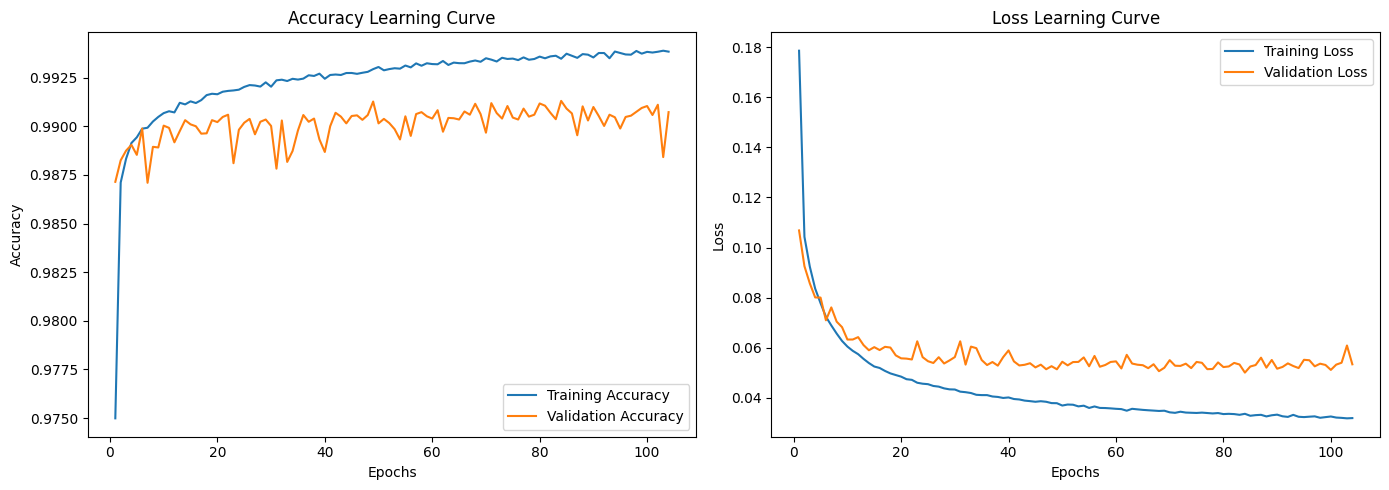

In [16]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Learning Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Learning Curve")
plt.legend()

plt.tight_layout()
plt.show()

### Learning Curve figure
In case cell outputs are cleared.

<img src="./model/keypoint_classifier/figures/learning_curve.png">

### Evaluation

In [18]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

823/823 [==============================] - 3s 4ms/step - loss: 0.0430 - accuracy: 0.9930


In [11]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [35]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 138ms/step
[9.9640638e-01 2.8249920e-06 4.6573441e-06 3.3774102e-04 1.3917532e-04
 1.6746545e-04 6.4081891e-05 8.8531307e-09 5.6728317e-07 5.5759801e-09
 1.3481927e-04 5.5995764e-09 8.9849912e-08 6.7437418e-06 3.5821620e-06
 3.9780705e-05 2.2962697e-05 4.9407586e-06 7.0146059e-05 6.7836532e-05
 2.5261270e-03 3.5279418e-11]
0


# Confusion matrix

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

3289/3289 [==============================] - 8s 2ms/step


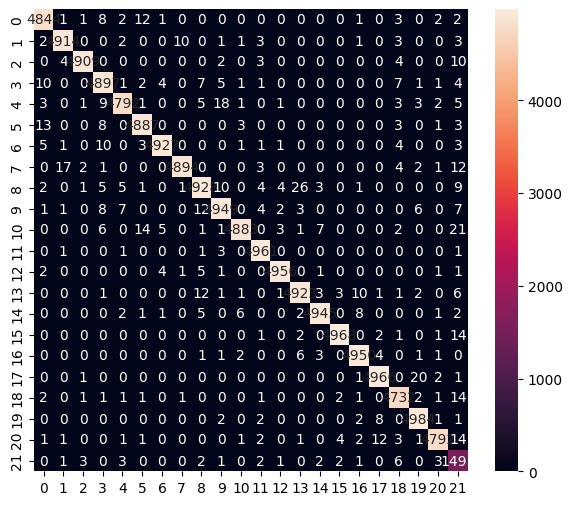

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4877
           1       0.99      0.99      0.99      4940
           2       1.00      1.00      1.00      4932
           3       0.99      0.99      0.99      4941
           4       0.99      0.99      0.99      4844
           5       0.99      0.99      0.99      4918
           6       1.00      0.99      1.00      4956
           7       1.00      0.99      0.99      4936
           8       0.99      0.99      0.99      5000
           9       0.99      0.99      0.99      5000
          10       1.00      0.99      0.99      4944
          11       0.99      1.00      1.00      4968
          12       1.00      1.00      1.00      4972
          13       0.99      0.99      0.99      4965
          14       1.00      0.99      1.00      4973
          15       1.00      1.00      1.00      4989
          16       0.99      1.00      1.00      4969
     

In [12]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

### Confusion matrix and classification report
In case the cell outputs are cleared.

<img src="./model/keypoint_classifier/figures/confusion_matrix.png">

<img src="./model/keypoint_classifier/figures/classification_report.png" width=40%>

# Convert to model for Tensorflow-Lite
More lightweight than a full model. Also runs lighter.

In [25]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\JAMIEY~1\AppData\Local\Temp\tmpepiq3nb8\assets


INFO:tensorflow:Assets written to: C:\Users\JAMIEY~1\AppData\Local\Temp\tmpepiq3nb8\assets


169720

# Inference test

In [6]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [28]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [33]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.96842384e-01 2.61661194e-06 2.78270318e-06 2.07303543e-04
 8.91360105e-05 1.74302768e-04 6.45283217e-05 6.68290134e-09
 4.18676194e-07 2.53059973e-09 1.12093054e-04 4.10470191e-09
 8.25645827e-08 4.48571927e-06 3.11055283e-06 4.63245051e-05
 2.41226153e-05 3.29388149e-06 2.69663669e-05 3.48415379e-05
 2.36112019e-03 5.31695209e-11]
0


### Re-evaluation of tflite model

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = input_details[0]['index']
output_index = output_details[0]['index']

Inference on full test set

In [14]:
y_true_lite = []
y_pred_lite = []

for i in range(len(X_test)):
    sample = X_test[i:i+1].astype(np.float32)

    interpreter.set_tensor(input_index, sample)
    interpreter.invoke()
    output = interpreter.get_tensor(output_index)
    pred = np.argmax(output)

    y_true_lite.append(y_test[i])
    y_pred_lite.append(pred)

y_true_lite = np.array(y_true_lite)
y_pred_lite = np.array(y_pred_lite)

Confusion matrix and classification report

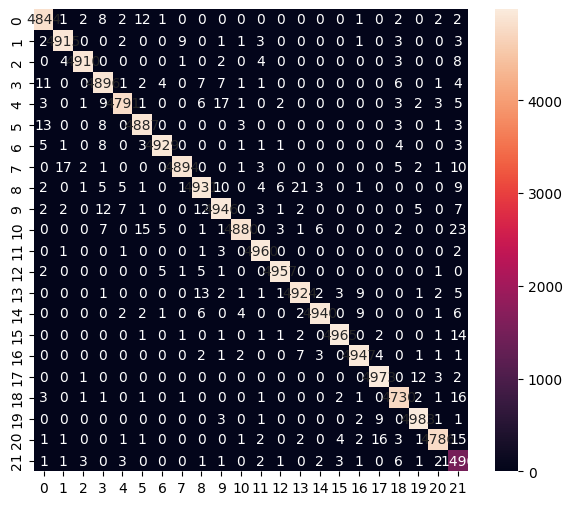

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4877
           1       0.99      0.99      0.99      4940
           2       1.00      1.00      1.00      4932
           3       0.99      0.99      0.99      4941
           4       1.00      0.99      0.99      4844
           5       0.99      0.99      0.99      4918
           6       1.00      0.99      1.00      4956
           7       1.00      0.99      0.99      4936
           8       0.99      0.99      0.99      5000
           9       0.99      0.99      0.99      5000
          10       1.00      0.99      0.99      4944
          11       0.99      1.00      1.00      4968
          12       1.00      1.00      1.00      4972
          13       0.99      0.99      0.99      4965
          14       1.00      0.99      1.00      4973
          15       1.00      1.00      1.00      4989
          16       0.99      1.00      1.00      4969
     

In [16]:
print(print_confusion_matrix(y_true_lite, y_pred_lite))

<img src="./model/keypoint_classifier/figures/confusion_matrix_lite.png" width=40%>

<img src="./model/keypoint_classifier/figures/classification_report_lite.png" width=40%>